In [1]:
import numpy as np
from tifffile import imread
from os import listdir
from pymatreader import read_mat
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2

In [70]:
mice = ['985', '900', '797', '826']
dFs = []

for mouse in mice :
    print("Mouse:", mouse)
    print("Loading data...")
    Fl = np.load(Path("/Volumes/Data2/seandarcy/complex_stimulus/mice", mouse, "2p/normal/TSeries/suite2p/plane0/F.npy"), allow_pickle=True)
    Fneu = np.load(Path("/Volumes/Data2/seandarcy/complex_stimulus/mice", mouse, "2p/normal/TSeries/suite2p/plane0/Fneu.npy"), allow_pickle=True)
    isCell = np.load(Path("/Volumes/Data2/seandarcy/complex_stimulus/mice", mouse, "2p/normal/TSeries/suite2p/plane0/iscell.npy"), allow_pickle=True)
    print("Calculating dF...")
    dF = Fl - (0.7*Fneu)
    print(dF.shape)
    dF = np.take(dF, np.where(isCell == 1)[0], axis = 0)
    print(dF.shape)
    dFs.append(dF)

Mouse: 985
Loading data...
Calculating dF...
(4912, 21000)
(2780, 21000)
Mouse: 900
Loading data...
Calculating dF...
(2080, 21000)
(1477, 21000)
Mouse: 797
Loading data...
Calculating dF...
(4527, 21000)
(2497, 21000)
Mouse: 826
Loading data...
Calculating dF...
(3177, 42000)
(2750, 42000)


In [71]:
stimHistories = []
for mouse in mice :
    if mouse != '826' :
        print("Mouse:", mouse)
        print("Loading data...")
        stimHistories.append(read_mat(Path("/Volumes/Data2/seandarcy/complex_stimulus/mice", mouse, "2p/normal/TSeries/suite2p/stimHist.mat"))['stimHistory'])

Mouse: 985
Loading data...
Mouse: 900
Loading data...
Mouse: 797
Loading data...


(2497, 21000)


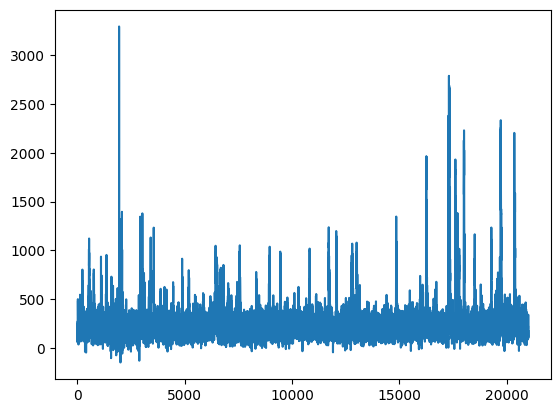

In [119]:
print(dFs[2].shape)
plt.figure()
plt.plot(dFs[2][7])


#this creates a data structure indexed by (LIST of mice(3), LIST of stimID(226), TENSOR of [rep(2), neurons(variable by mouse), frames(15)])
orderedData = []
#skip last mouse that has concatenated data
for mouse in range(len(mice) - 1) : 
    neurons = []
    for j in range(226) :
        reps = []
        for i in range(2) :
            start = stimHistories[mouse][j, i] - 1
            end = stimHistories[mouse][j, i] + 14
            reps.append(ToTensor()(dFs[mouse][:, start:end]))
    #this will need to change when nreps is changed
        neurons.append(torch.squeeze(torch.stack((reps[0], reps[1]), 0)))
    orderedData.append(neurons)


In [148]:
#ORDERED DATA is (List of mice(3), stimID(226), rep(2), neurons(variable by mouse), frames(15))

print(orderedData[0][0].shape)

maxNeurons = np.zeros((226, 2, 1))
#iterate through stims for a mouse
for (i, stimId) in enumerate(orderedData[0]) :
    #compute mean activation over 15 frames of stim for each neuron and rep
    avg = torch.mean(stimId, axis = 2)

    #iterate through repetitions
    for rep in range(2) :
        maxNeurons[i, rep] = torch.argmax(avg[rep, :])


#maxNeurons contains the indices (neuron labels) of highest mean responsive (over 15 frames) to a particular stim for each rep (226, 2), values correspond to neuron index

torch.Size([2, 2780, 15])


Most Responsive Neuron Rep 1: 41
Most Responsive Neuron Rep 2: 41


Text(0.5, 0, 'Frame')

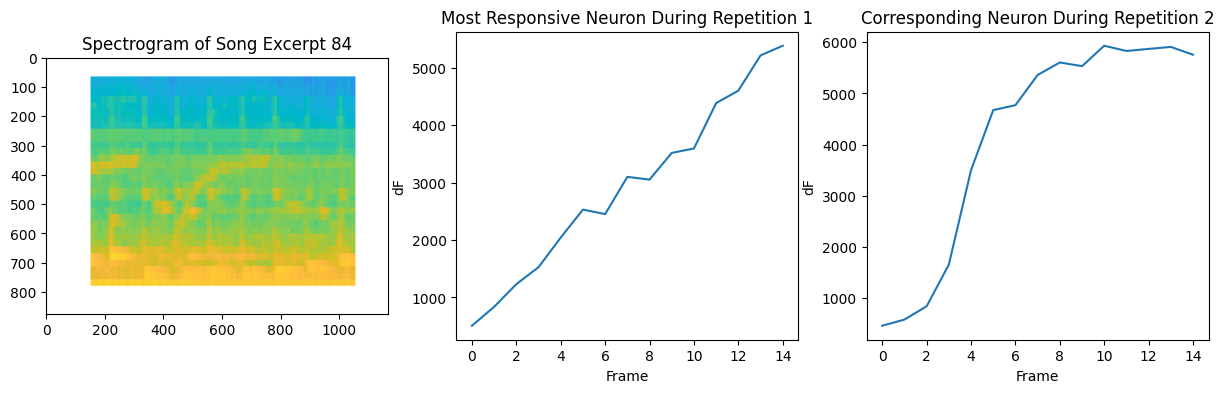

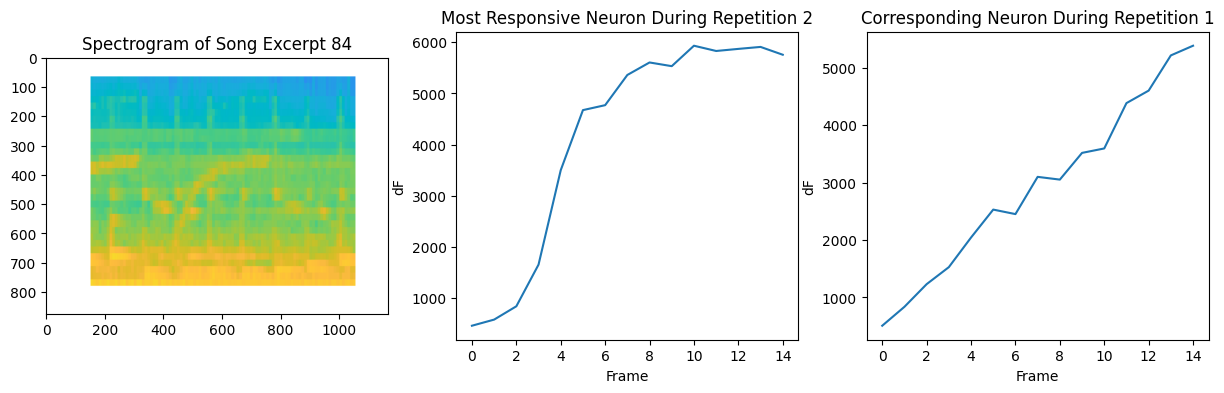

In [194]:
#print(orderedData[0][0].shape)

mouseInd = 0

maxNeurons = np.zeros((226, 2, 1))
#iterate through stims for a mouse
for (i, stimId) in enumerate(orderedData[mouseInd]) :
    #compute mean activation over 15 frames of stim for each neuron and rep
    avg = torch.mean(stimId, axis = 2)

    #iterate through repetitions
    for rep in range(2) :
        maxNeurons[i, rep] = torch.argmax(avg[rep, :])

stimulus = 84
#stimulus = 26
#stimulus = 49



spec = torchvision.io.read_image("newMelSpecs/" + str(stimulus) + ".png")

mR1 = int(maxNeurons[stimulus][0][0])
mR2 = int(maxNeurons[stimulus][1][0])

print("Most Responsive Neuron Rep 1:", mR1)
print("Most Responsive Neuron Rep 2:", mR2)

plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
plt.title("Spectrogram of Song Excerpt " +str(stimulus))
plt.imshow(spec.permute(1,2,0))

plt.subplot(1, 3, 2)
plt.plot(orderedData[mouseInd][stimulus][0][mR1][:])
plt.title("Most Responsive Neuron During Repetition 1")
plt.ylabel("dF")
plt.xlabel("Frame")

plt.subplot(1, 3, 3)
plt.plot(orderedData[mouseInd][stimulus][1][mR1][:])
plt.title("Corresponding Neuron During Repetition 2")
plt.ylabel("dF")
plt.xlabel("Frame")

plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
plt.title("Spectrogram of Song Excerpt " +str(stimulus))
plt.imshow(spec.permute(1,2,0))

plt.subplot(1, 3, 2)
plt.plot(orderedData[mouseInd][stimulus][1][mR2][:])
plt.title("Most Responsive Neuron During Repetition 2")
plt.ylabel("dF")
plt.xlabel("Frame")

plt.subplot(1, 3, 3)
plt.plot(orderedData[mouseInd][stimulus][0][mR2][:])
plt.title("Corresponding Neuron During Repetition 1")
plt.ylabel("dF")
plt.xlabel("Frame")



In [6]:
#bin = Path("/Volumes/Data2/seandarcy/complex_stimulus/mice/900/cs_m900_2p-008/suite2p/plane0/spks.npy")

bin = Path("/Volumes/Data2/seandarcy/complex_stimulus/mice/900/2p/normal/TSeries/suite2p/plane0/spks.npy")

#stimHist = Path("/Volumes/Data2/seandarcy/220804/cs_m900_2p-008/suite2p/stimHist.mat")
#stimHist = Path("/Volumes/Data2/seandarcy/complex_stimulus/mice/900/cs_m900_2p-008/suite2p/stimHist.mat")


stimHist = Path("/Volumes/Data2/seandarcy/complex_stimulus/mice/900/2p/normal/TSeries/suite2p/stimHist.mat")

specs = Path("newMelSpecs")


class NeuralDataset(Dataset) :
#tiff_path is path to .tiff files containing widefield images
#spec_path is path to spectrograms
#timeStamps is .mat file that is stims x nReps, containing frame info
    def __init__(self, bin_path, spec_path, timeStamps, reps = 2, transforms = None):
        self.specs = listdir(spec_path)
        self.specs = sorted(self.specs, key=lambda fname: int(fname.split('.')[0]))
        self.reps = reps
        self.spikes = np.load(bin_path, allow_pickle=True)
        #spikes is 2080 by 21000
        self.timeStamps = read_mat(timeStamps)['stimHistory']
        self.transform = transforms
  
    def __len__(self):
            return len(self.specs)

    def __reps__(self):
            return self.reps

    def __getitem__(self, idx):
        reps = []
        for i in range(self.reps) :
            start = self.timeStamps[idx, i] - 1
            end = self.timeStamps[idx, i] + 14
            reps.append(ToTensor()(self.spikes[:, start:end]))
            
        #this will need to change when nreps is changed
        neurons = torch.squeeze(torch.stack((reps[0], reps[1]), 0))
        spec = torchvision.io.read_image("newMelSpecs/" + self.specs[idx])
        return neurons, spec
        
dataset = NeuralDataset(bin, specs, stimHist)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

(2080, 21000)


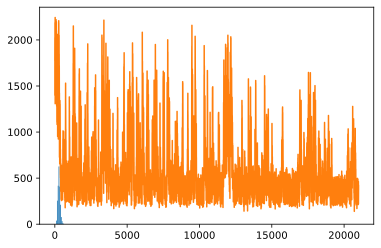

In [351]:
#Raw F trace
#
#F = np.load(bin, allow_pickle=True)

print(F.shape)
plt.hist(np.mean(F,axis=1))
plt.plot(F[0,:])


torch.Size([2, 4912, 15])
torch.Size([3, 875, 1167])


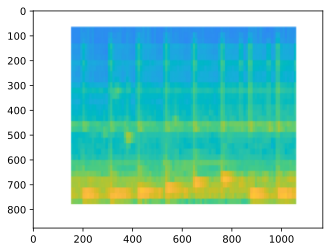

In [297]:
neu, spec = dataset[5]
print(dataset[0][0].shape)

print(spec.shape)
plt.imshow(spec.permute(1,2,0))
#neu shape is [repetition (2) x neurons (2048) x 15 (frames)]

(2, 2080, 3390)


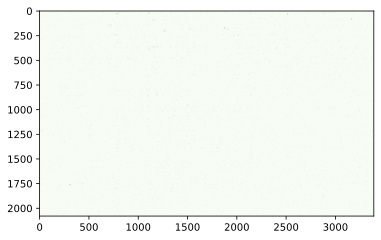

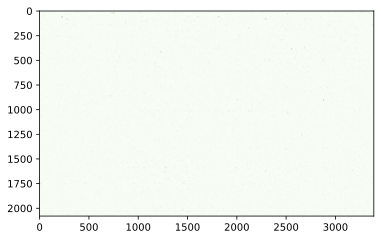

In [355]:
#visualize spikemaps
spikemaps = []

rufus_activation = np.zeros((2, 2080, 3390))
print(rufus_activation.shape)
for i, (neu, spec) in enumerate(dataloader) :
    rufus_activation[:, :, i*15 : i*15 + 15] = neu  


for k in range(2) :
    img = rufus_activation[k, :, :]
    img = 255.0 * ((img - np.min(img)) / (np.max(img) - np.min(img)))
    spikemaps.append(img)
    plt.imshow(img, cmap='Greens', interpolation='nearest')
    plt.show()


(3390, 3)
[0.0264614  0.02050698 0.0164111 ]


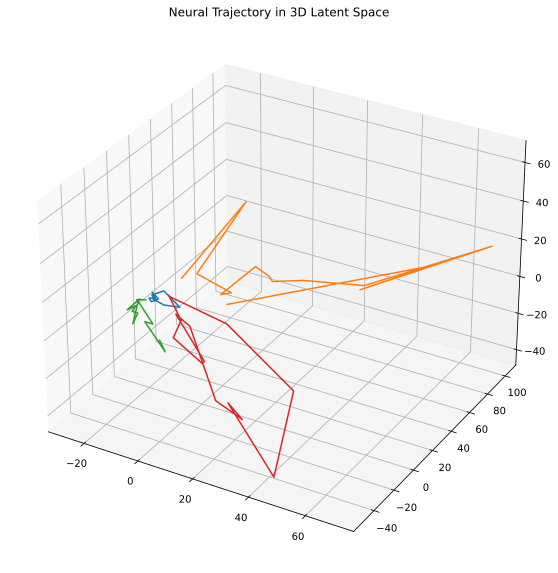

(3390, 3)
[0.01991194 0.01455413 0.01004638]


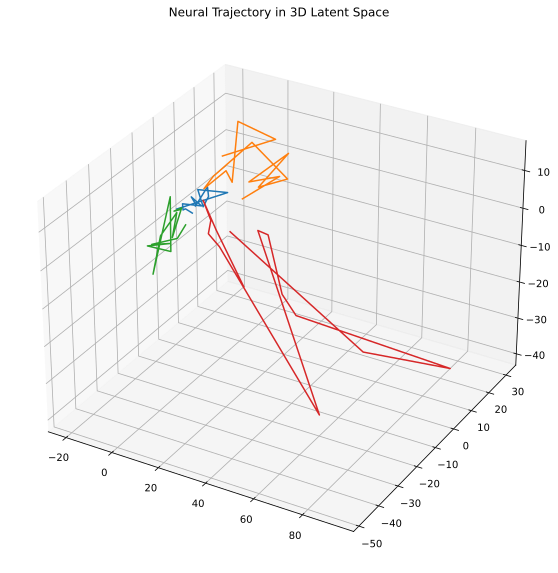

In [356]:
import sklearn
from sklearn import decomposition
from mpl_toolkits import mplot3d

pca = sklearn.decomposition.PCA(n_components=3)

for k in range(2) :
    

    pcs = pca.fit_transform(spikemaps[k].T)
    print(pcs.shape)
    print(pca.explained_variance_ratio_)

    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')

    for i in range(4) :
        #neu, spec = dataset[i]
        start = 15*i
        end = 15*(i+1) - 1
        ax.plot3D(pcs[start:end, 0], pcs[start:end, 1], pcs[start:end, 2])

    plt.title("Neural Trajectory in 3D Latent Space")
    plt.show()


In [300]:
#reps x distinct stimuli
trials = dataset.__reps__() * dataset.__len__()

#distinct stimuli
trial_types = dataset.__len__()


print('Number of trials: {}'.format(trials))
print('Types of trials (distinct stimuli): {}'.format(trial_types)) 
print('Dimensions of single trial array (# neurons by # time points): {}'.format(spikemaps[k][:, 0:15].shape))

Number of trials: 452
Types of trials (distinct stimuli): 226
Dimensions of single trial array (# neurons by # time points): (4912, 15)


In [329]:
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#specify sequence of interest for plotting
seqOI = (0, 4)

shade_alpha      = 0.2
lines_alpha      = 0.8
pal = sns.color_palette('husl', seqOI[1])
%config InlineBackend.figure_format = 'svg'

def add_stim_to_plot(ax):
    ax.axvspan(0, 15, alpha=shade_alpha,
               color='gray')
    ax.axvline(0, alpha=lines_alpha, color='gray', ls='--')
    ax.axvline(15, alpha=lines_alpha, color='gray', ls='--')
    
def add_orientation_legend(ax):
    custom_lines = [Line2D([0], [0], color=pal[k], lw=4) for
                    k in range(seqOI[0], seqOI[1])]
    labels = ['{}'.format(t) for t in range(seqOI[0], seqOI[1])]
    ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0,0,0.9,1])

In [302]:

#average response over frames 
trial_response = np.zeros((4912, 452))

#average response over reps
trial_avg = np.zeros((4912, 3390))

#neurons x [frames x reps]
trial_concat = np.zeros((4912, 3390 * 2))

for i, (neu, specs) in enumerate(dataloader) :
    neu = neu.squeeze()
    trial_response[:, i : i+2] = torch.mean(neu, dim = 2).T
    trial_avg[:, i : i + 15] = torch.mean(neu, dim = 0)
    trial_concat[:, i : i + 30] = torch.cat((neu[0, :, :], neu[1, :, :]), dim = -1)


print(trial_response.shape)
print(trial_avg.shape)
print(trial_concat.shape)

(4912, 452)
(4912, 3390)
(4912, 6780)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(4912, 452)
(15, 452)


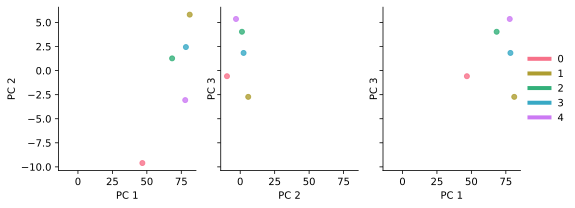

In [303]:
#trial response PCA

def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

pca = PCA(n_components=15)
Xr_sc = z_score(trial_response)
Xp = pca.fit_transform(Xr_sc.T).T

projections = [(0, 1), (1, 2), (0, 2)]
fig, axes = plt.subplots(1, 3, figsize=[9, 3], sharey='row', sharex='row')
for ax, proj in zip(axes, projections):
    for t in range(seqOI[0], seqOI[1]):
        x = Xp[proj[0], t]
        y = Xp[proj[1], t]
        ax.scatter(x, y, c=pal[t], s=25, alpha=0.8)
        ax.set_xlabel('PC {}'.format(proj[0]+1))
        ax.set_ylabel('PC {}'.format(proj[1]+1))
sns.despine(fig=fig, top=True, right=True)
add_orientation_legend(axes[2])

print(Xr_sc.shape)
print(Xp.shape)


(3, 3390)


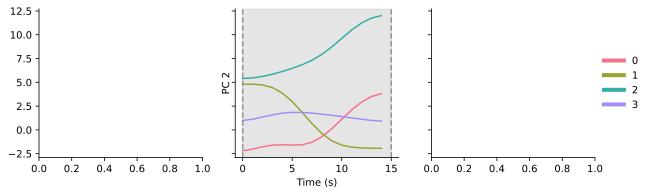

In [339]:
#trial avg PCA
from scipy.ndimage.filters import gaussian_filter1d

Xa = z_score(trial_avg) 
Xa_p = pca.fit_transform(Xa.T).T

print(Xa_p.shape)

fig, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey='row')
for comp in range(1, 2):
    ax = axes[comp]
    for kk in range(seqOI[0], seqOI[1]):
        x = Xa_p[comp, kk*15 : kk*15 + 15]
        x = gaussian_filter1d(x, sigma=3)
        ax.plot(range(0, 15), x, c=pal[kk])
    add_stim_to_plot(ax)
    ax.set_ylabel('PC {}'.format(comp+1))
add_orientation_legend(axes[2])
axes[1].set_xlabel('Time (s)')
sns.despine(fig=fig, right=True, top=True)
plt.tight_layout(rect=[0, 0, 0.9, 1])




(3,)


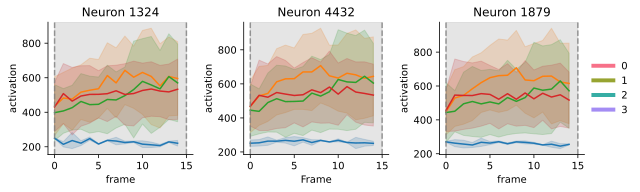

In [337]:
import pandas as pd
# find the indices of the three largest elements of the second eigenvector
units = np.abs(pca.components_[1, :].argsort())[::-1][0:3]
print(units.shape)



f, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey=False,
                       sharex=True)


for ax, unit in zip(axes, units):
    ax.set_title('Neuron {}'.format(unit))

    for l in range(seqOI[0], seqOI[1]) :
        df = np.zeros((30, 3))
        m = 0
        for rep in range(dataset.__reps__()) :
            tempDf = np.zeros((1, 3))
            tempDf[0, 0] = rep
            for frame in range(15) :
                tempDf[0, 1] = frame
                tempDf[0, 2] = dataset[l][0][rep, unit, frame]
                df[m, :] = tempDf
                m += 1
        px = pd.DataFrame(df, columns = ['rep', 'frame', 'activation'])
        sns.lineplot(data = px, x = 'frame', y = 'activation', ax=ax,
                   err_style='band',
                   ci=95)
for ax in axes:
    add_stim_to_plot(ax)

axes[1].set_xlabel('Frame')
sns.despine(fig=f, right=True, top=True)
add_orientation_legend(axes[2])

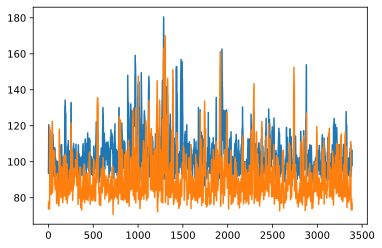

In [349]:
plt.plot(spikemaps[1][1326])
plt.plot(spikemaps[0][1326])

<ipython-input-329-cc3a513e7e66>:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0,0,0.9,1])


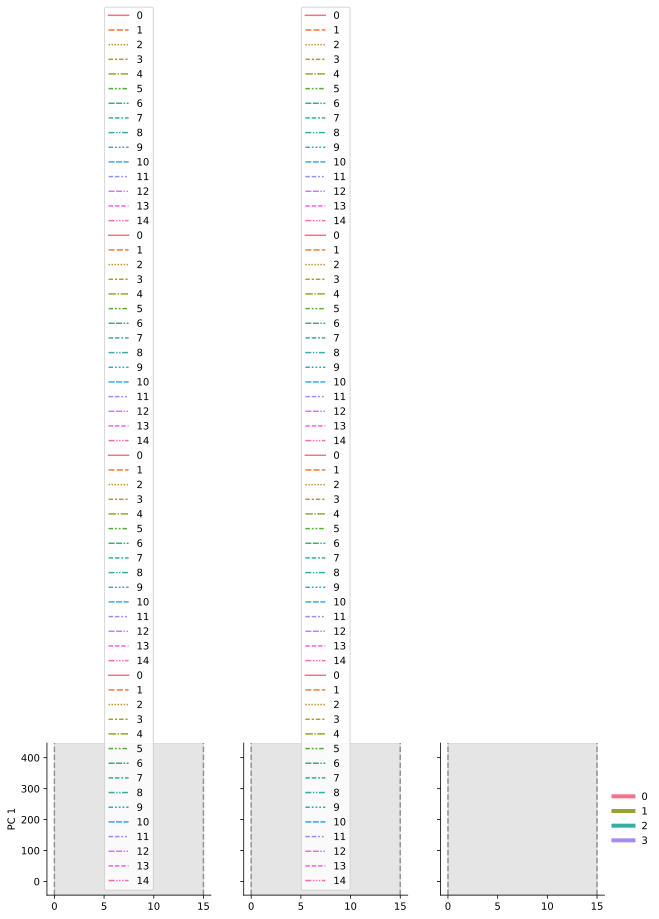

In [336]:
#trial concatenated pca 
n_components = 3
Xl = z_score(trial_concat)
pca = PCA(n_components)
Xl_p = pca.fit_transform(Xl.T).T

#edit this out 
gt = {comp : {k : [] for k in range(seqOI[0], seqOI[1])} for comp in range(n_components)}

for comp in range(n_components):
    for t in range(seqOI[0], seqOI[1]):
        r = Xl_p[comp, t*15 : t*15 + 15]
        gt[comp][t].append(r)

for comp in range(n_components):
    for t in range(seqOI[0], seqOI[1]):
        gt[comp][t] = np.vstack(gt[comp][t])

f, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey=True, sharex=True)
for comp in range(3):
    ax = axes[comp]
    for k in range(seqOI[0], seqOI[1]):
        sns.lineplot(data = gt[comp][k], ax=ax, err_style='band',ci=95)
    add_stim_to_plot(ax)
    ax.set_ylabel('PC {}'.format(comp+1))
    #axes[1].set_xlabel('Time (s)')

sns.despine(right=True, top=True)
add_orientation_legend(axes[2])